In [1]:
import params 
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import torch
import torchaudio

In [2]:
train_data = np.load(params.datafile)
train_label = np.load(params.labelfile)

test_data = np.load(params.testfile)
test_label = np.load(params.testlabelfile)

In [3]:
print(train_data.shape)
print(test_data.shape)

(771232, 250)
(777419, 250)


97126 49361
[ 2.900e+01-6.200e+01j  2.900e+01-4.000e+00j  1.600e+01-5.000e+00j
 -2.000e+00+3.900e+01j -1.700e+01+4.600e+01j -1.950e+02+1.080e+02j
  4.700e+01-3.100e+01j -7.800e+01+3.900e+01j -4.000e+01-1.400e+01j
  1.600e+01-3.000e+00j  7.000e+00+9.000e+00j  2.800e+01-3.300e+01j
 -3.100e+01-3.700e+01j  2.900e+01+5.300e+01j  4.100e+01+3.300e+01j
  5.100e+01+1.500e+01j -3.000e+01-9.400e+01j -3.300e+01-3.300e+01j
 -5.800e+01+9.000e+00j -1.000e+02+8.700e+01j -5.500e+01+6.400e+01j
 -1.700e+01-1.800e+01j -6.700e+01-4.800e+01j  1.980e+02-5.700e+01j
  9.400e+01+4.700e+01j  3.600e+01+5.100e+01j  5.300e+01+3.100e+01j
  1.500e+01+2.400e+01j  5.000e+00-3.100e+01j  1.180e+02+2.400e+01j
 -5.200e+01+9.100e+01j  1.670e+02-5.300e+01j -9.000e+01+2.000e+00j
 -5.000e+00+1.400e+01j  2.800e+01+2.400e+01j  6.200e+01+6.400e+01j
  4.500e+01+5.300e+01j  2.800e+01-3.500e+01j -1.700e+01-4.600e+01j
 -7.910e+02+4.720e+02j -5.839e+03+3.683e+03j -6.462e+03+5.086e+03j
 -6.237e+03+5.518e+03j -5.975e+03+5.828e+03j -4.77

/home/thibaua25/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


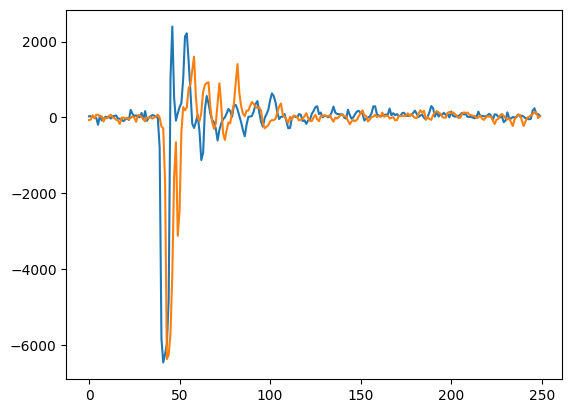

In [4]:
# Sample 1 train and 1 test
r1, r2 = np.random.choice(100000, 2)
print(r1, r2)
X1 = train_data[r1]
X2 = test_data[r2]

print(X1)

plt.plot(X1)
plt.plot(X2)

plt.show()

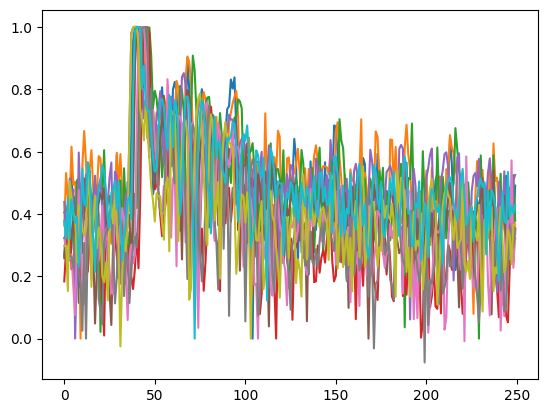

In [5]:
# Testing the logarithmic distortion

eps = 1e-5

for i in range(10):
    X1 = train_data[i]
    
    logX1 = np.log(X1+eps)

    logX1 = (logX1 - logX1.min())/(logX1.max() - logX1.min())

    plt.plot(logX1)
    # plt.plot(X1)

plt.show()

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

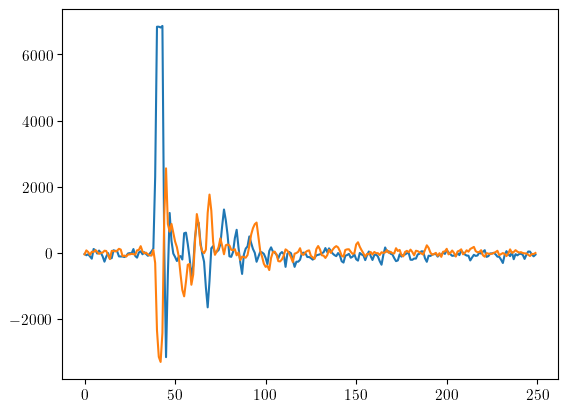

torch.Size([128, 126])
torch.Size([128, 126, 2])


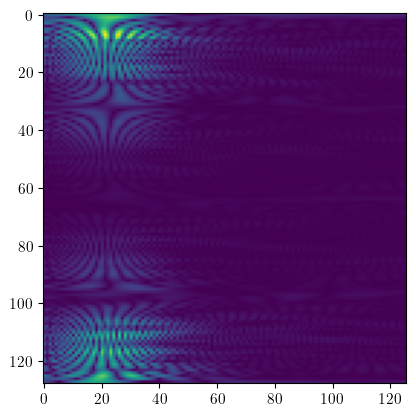

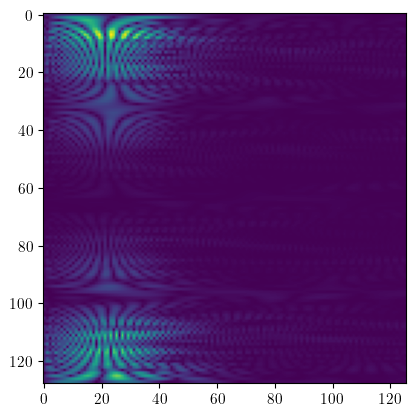

tensor([[[0.3106, 0.0983],
         [0.3123, 0.0988],
         [0.3173, 0.1003],
         ...,
         [0.1017, 0.0039],
         [0.1017, 0.0041],
         [0.1017, 0.0041]],

        [[0.2074, 0.0460],
         [0.2207, 0.0263],
         [0.2231, 0.0993],
         ...,
         [0.0573, 0.0133],
         [0.0549, 0.0142],
         [0.0525, 0.0148]],

        [[0.2471, 0.0796],
         [0.2570, 0.0779],
         [0.2769, 0.0725],
         ...,
         [0.0006, 0.0172],
         [0.0020, 0.0161],
         [0.0040, 0.0147]],

        ...,

        [[0.3739, 0.0852],
         [0.3249, 0.2024],
         [0.2427, 0.2987],
         ...,
         [0.0084, 0.0086],
         [0.0115, 0.0059],
         [0.0137, 0.0020]],

        [[0.2471, 0.0796],
         [0.2472, 0.0826],
         [0.2558, 0.0911],
         ...,
         [0.0056, 0.0130],
         [0.0040, 0.0147],
         [0.0020, 0.0161]],

        [[0.2074, 0.0460],
         [0.1835, 0.1156],
         [0.1495, 0.1809],
         ...,
 

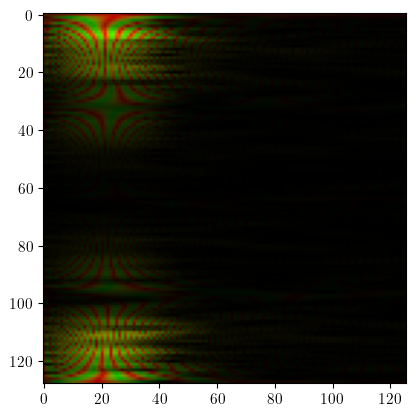

In [73]:
import matplotlib as mpl
# Enable LaTeX formatting
mpl.rcParams['text.usetex'] = True
# Set the global font to be Times New Roman, size 11
mpl.rc('font', family='Times New Roman', size=11)

params.spectrogram_window_size = 128
params.spectrogram_hop_size = 2
pad_value = 0

signal = train_data[1]
signal = torch.from_numpy(signal)
plt.plot(torch.view_as_real(signal))
plt.show()
spectrogram = torchaudio.transforms.Spectrogram(n_fft=params.spectrogram_window_size, hop_length=params.spectrogram_hop_size, power=None, normalized=True, onesided=False, pad=pad_value)
x = spectrogram(signal)
print(x.shape)
x = torch.view_as_real(x)
print(x.shape)

x = torch.abs(x)

x = (x - x.min())/(x.max() - x.min())

plt.imshow(x[:, :, 0])
plt.show()
plt.imshow(x[:, :, 1])
plt.show()
print(x)

# Normalisation
# x -= x.min(1, keepdim=True)[0]
# x /= x.max(1, keepdim=True)[0]
x = torch.cat((x, torch.zeros(x.shape[0], x.shape[1], 1)), axis=-1) 
print(x)
print(x.shape)
plt.imshow(x)
plt.show()

Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False
100


/tmp/ipykernel_1960726/4169195397.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  signal = torch.from_numpy(signal.astype(np.float32))


TypeError: 'AxesImage' object is not subscriptable

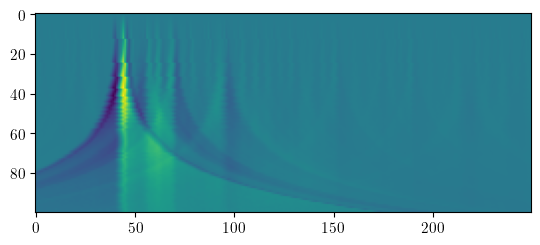

In [70]:
import matplotlib as mpl
import pywt
import ptwt
# Enable LaTeX formatting
mpl.rcParams['text.usetex'] = True
# Set the global font to be Times New Roman, size 11
mpl.rc('font', family='Times New Roman', size=11)

params.spectrogram_window_size = 64
params.spectrogram_hop_size = 4
pad_value = 28

signal = train_data[10]
signal = torch.from_numpy(signal.astype(np.float32))
# plt.plot(torch.view_as_real(torch.from_numpy(signal)))
# plt.show()

# perform CWT
# wavelet = "cmor2.5-2.5"
wavelet = pywt.Wavelet('haar')
# logarithmic scale for scales, as suggested by Torrence & Compo:
# sampling_period = np.diff(10).mean()

widths = np.geomspace(1, 1024//4, num=100)

# print(signal[0])
cwtmatr, freqs = ptwt.cwt(signal, widths, wavelet)
print(wavelet)
print(len(cwtmatr))

plt.imshow(cwtmatr)[:, :, 0]
plt.show()


plt.plot(cwtmatr)
plt.show()

# widths = np.geomspace(1, 1024//4, num=100)
# cwtmatr, freqs = pywt.cwt(signal, widths, wavelet)
# # absolute take absolute value of complex result
# cwtmatr = np.abs(cwtmatr[:-1, :-1])

# print(cwtmatr.shape)
# plt.imshow(cwtmatr)
# plt.show()

# x = torch.view_as_real(x)
# x = torch.abs(x)

# x = (x - x.min())/(x.max() - x.min())

# plt.imshow(x[:, :, 0])
# plt.show()
# plt.imshow(x[:, :, 1])
# plt.show()

In [8]:
sample_size = 502

pos_ids = [np.where(train_label[:,1] == i) for i in range(params.num_pos)]
dev_ids = [np.where(train_label[:,0] == i) for i in range(params.num_dev)]

all_data = []
for i in range(params.num_dev) :
    all_data.append([])
    for k in range(params.num_pos) :
        # Make the union between dev and pos befor getting the time separation
        inter_ids = list(set(dev_ids[i][0]) & set(pos_ids[k][0]))
        inter_ids = inter_ids[:sample_size]
        # Abs of complex value
        all_data[i].append([list(map(np.abs, train_data[inter_ids[j]])) for j in range(len(inter_ids))])

all_data = np.array(all_data)
print(all_data.shape)

KeyboardInterrupt: 

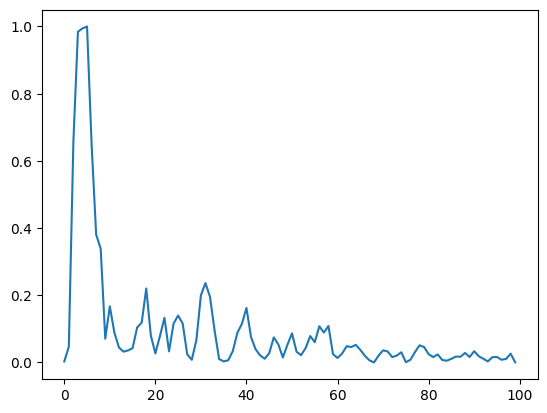

In [ ]:
def diff_centering(x):
    start = np.argmax(np.diff(x))
    x = x[start-1:start+99]
    x = (x - x.min())/(x.max() - x.min())
    return x

x = diff_centering(all_data[0, 0, 0])
plt.plot(x)
plt.show()

In [ ]:
clean_data = []
for i in range(len(all_data)):
    clean_data.append([])
    for j in range(len(all_data[i])):
        # Filter the argmax that is to early
        filtered = list(filter(lambda x: np.argmax(np.diff(x)) > 3, all_data[i, j]))
        if len(filtered) < 500:
            print(len(filtered))
        # Map the centering function
        clean_data[i].append(list(map(diff_centering, filtered[:sample_size-2])))

clean_data = np.array(clean_data)

(9, 48, 100)
inter_pos 0.8975666368922298
inter_dev 0.9366345160339165
[(0.4, 0.7607843137254902, 0.6470588235294118), (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), (0.5529411764705883, 0.6274509803921569, 0.796078431372549), (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), (1.0, 0.8509803921568627, 0.1843137254901961), (0.8980392156862745, 0.7686274509803922, 0.5803921568627451), (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]


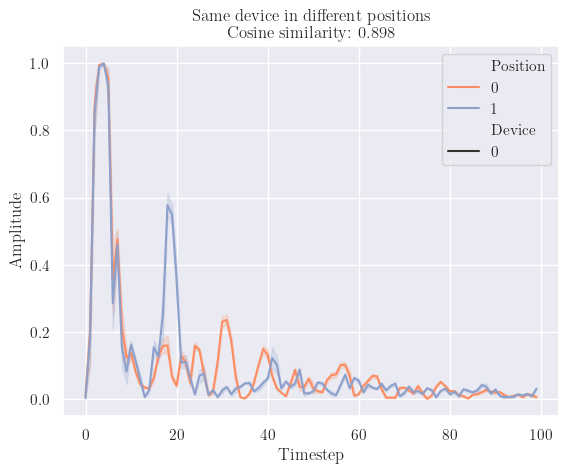

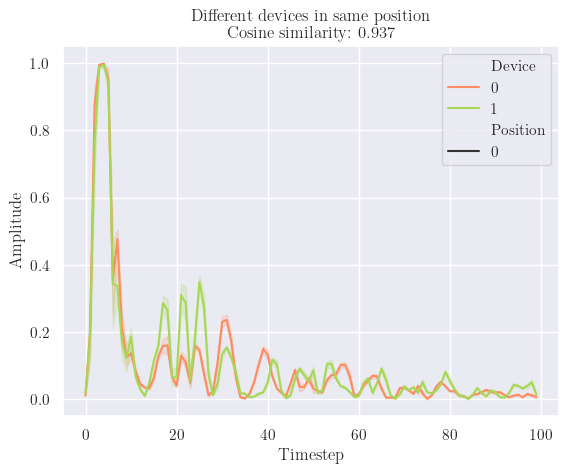

In [ ]:
import matplotlib as mpl
# Enable LaTeX formatting
mpl.rcParams['text.usetex'] = True
# Set the global font to be Times New Roman, size 11
mpl.rc('font', family='Times New Roman', size=11)

# sns.set_theme(style="darkgrid")
nb_sample = 10

list_mean_values = np.mean(clean_data[:, :, :nb_sample], axis=2)
print(list_mean_values.shape)

dev_todo = [0, 1]
pos_todo = [0, 1]
frame_data = []
for dev in dev_todo:
    for pos in pos_todo:
        for i in range(nb_sample):
            for j in range(len(clean_data[dev, pos, i])):
                frame_data.append([clean_data[dev, pos, i, j], j, dev, pos])

df_data =pd.DataFrame(frame_data, columns=["Amplitude", "Timestep", "Device", "Position"])

inter_pos = cosine_similarity(clean_data[dev_todo[0], pos_todo[0]], clean_data[dev_todo[0], pos_todo[1]])
print("inter_pos", np.mean(inter_pos))
inter_dev = cosine_similarity(clean_data[dev_todo[0], pos_todo[0]], clean_data[dev_todo[1], pos_todo[0]])
print("inter_dev", np.mean(inter_dev))

colors = sns.color_palette("Set2")
print(colors)

# Same device
sns.lineplot(df_data[df_data["Device"]==dev_todo[0]], x="Timestep", y="Amplitude", hue="Position", style="Device", 
             palette=[colors[1], colors[2]])
plt.title("Same device in different positions \n Cosine similarity: {:.3f}".format(np.mean(inter_pos)))
plt.savefig('/home/thibaua25/Documents/slide factory/Fingerprints/signal_same_position.png', dpi=200)
plt.show()
sns.lineplot(df_data[df_data["Position"]==pos_todo[0]], x="Timestep", y="Amplitude", hue="Device", style="Position",
             palette=[colors[1], colors[4]])
plt.title("Different devices in same position \n Cosine similarity: {:.3f}".format(np.mean(inter_dev)))
plt.savefig('/home/thibaua25/Documents/slide factory/Fingerprints/signal_same_device.png', dpi=200)
plt.show()

# sns.relplot(data=pd.DataFrame(clean_data[1, 25, :nb_sample]), kind="line")

# plt.plot(list_mean_values[1, 1])
# plt.plot(list_mean_values[1, 20])
# plt.show()

# plt.plot(list_mean_values[1, 1])
# plt.plot(list_mean_values[2, 1])
# plt.show()